# Simple Neural Network

## 1. Data Procedure

- We could initialize a dataloader instance to get what it is like: 

In [1]:
# import the DataLoader
from src.data.DataLoader import DataLoader

# Assuming 'data.csv' is in a folder named 'dataset/data' in the src directory
file_path = 'dataset/data/data.csv'

# Create an instance of DataLoader
data_loader_0 = DataLoader(file_path, shuffle=True)  # setting shuffle to True for testing

# Load the data
data = data_loader_0.load_data()

# Print the first few rows of the data to verify loading
print(data.head())

# Print what type of data is returned
print(type(data))

         x1        x2  target
0  5.631940  5.660647       1
1  4.189212  5.118591       1
2  2.817359  3.116649       1
3  4.056573  6.153570       1
4  4.245637  4.682332       1
<class 'pandas.core.frame.DataFrame'>


- data_loader is now created, we initialize a data_processor to handle the file

In [2]:
# Import necessary classes
from src.data.DataProcessor import DataProcessor

# Load data using DataLoader (if not already loaded)
data = data_loader_0.load_data()

# Create an instance of DataProcessor
# Assuming normalization is desired and the default split proportions are fine
data_processor_0 = DataProcessor(data_loader_0, normalize=True)

# Process the data to get train, validation, and test sets
train_data, validate_data, test_data = data_processor_0.process_data()

# Optionally, print the shapes of the datasets to verify everything is as expected
print("Train Data Shape:", train_data.shape)
print("Validation Data Shape:", validate_data.shape)
print("Test Data Shape:", test_data.shape)


Train Data Shape: (700, 3)
Validation Data Shape: (150, 3)
Test Data Shape: (150, 3)


- Using BaseDataset to directly create splited and normalized datasets

In [3]:
from src.data.BaseDataset import BaseDataset

# Assume file_path is correctly defined relative to the script running this code
dataset = BaseDataset('dataset/data/data.csv', shuffle=True, normalize=True)
train_data, validate_data, test_data = dataset.prepare_data()

# Optionally, directly access data from the dataset object later
print(dataset.train_data.head())
print(dataset.validate_data.head())
print(dataset.test_data.head())


           x1        x2  target
831  0.604802 -0.005123       1
268  0.649503  1.011380       1
297  0.135511  1.596099       1
64  -0.098061  0.962732       1
397  0.642801  0.458327       1
           x1        x2  target
66  -0.681642 -1.292766       0
117  0.110795  1.147304       1
570 -1.873349 -1.584307       0
600  0.268702 -0.400267       1
173 -1.132041 -1.711151       0
           x1        x2  target
423  1.070141  0.277232       1
536 -1.783342 -0.757826       0
654 -1.915517 -1.735341       0
579  1.199264  1.127927       1
556  1.093485  0.082636       1


- Using matplotlib to plot SOME of the data features

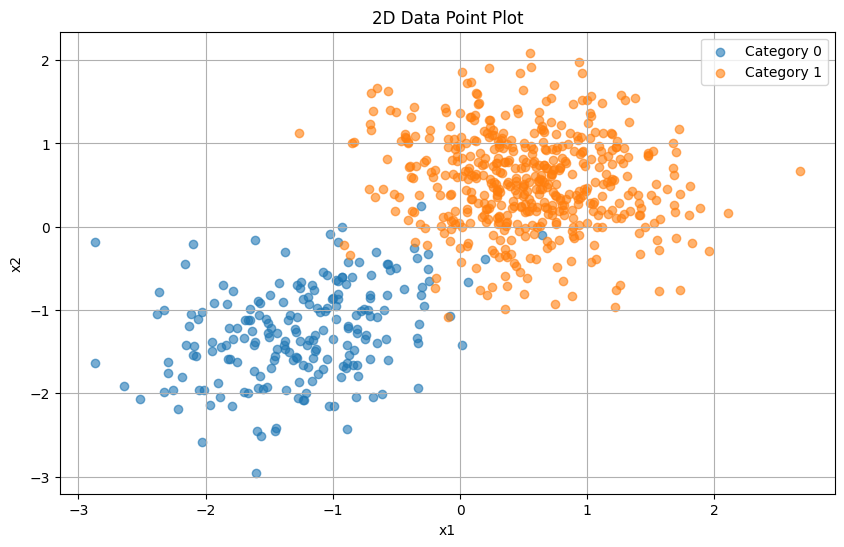

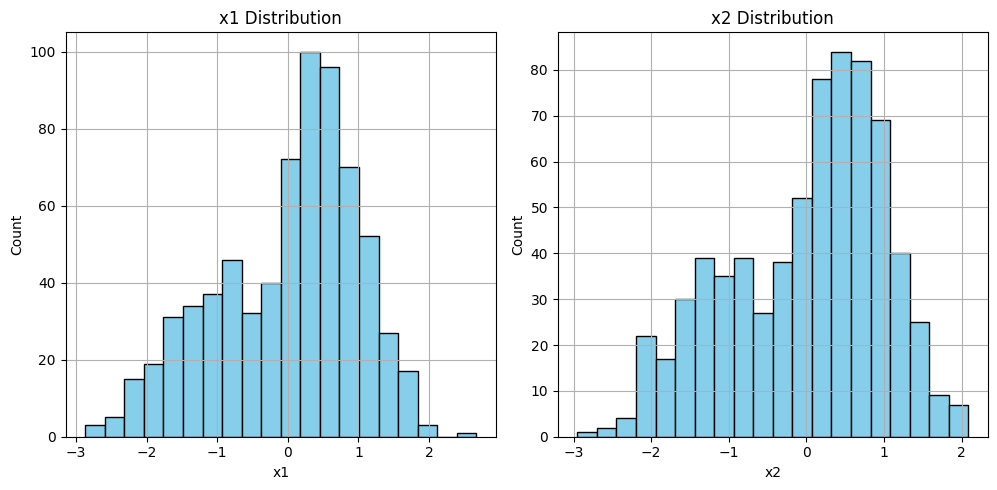

In [4]:
from src.data.Utils_Data import plot_all_histograms
from src.data.Utils_Data import plot_2d_data

# Assuming `df_2D` is the DataFrame containing your 2D dataset
plot_2d_data(dataset.train_data, feature_columns=['x1', 'x2'], label_column='target')

# Plotting the histogram of train_data for 'x1'
plot_all_histograms(dataset.train_data, exclude_columns=['target'])


## 2. Modeling Procedure
### 2.1 Forward passing
- After implementing BaseNetwork and the inherited ClassifierNetwork, we can test its forward pass

In [5]:
from src.models.ClassifierNetwork import Classifier
# Get the number of features from the dataset
num_features = dataset.train_data.shape[1] - 1  # Subtract 1 for the target column
# Assuming you have a ClassifierNetwork class already imported and ready
classifier = Classifier(num_features)  # Initialize with 2 features as your dataset suggests,

# Extract features and targets from prepared data
X_train = train_data.drop('target', axis=1).values
y_train = train_data['target'].values

X_val = validate_data.drop('target', axis=1).values
y_val = validate_data['target'].values

X_test = test_data.drop('target', axis=1).values
y_test = test_data['target'].values

# Perform a forward pass with the training data
train_preds = classifier.forward(X_train)
print("Training Predictions Shape:\n", train_preds.shape)
print("Some Training Predictions:\n", train_preds[:5])


Training Predictions Shape:
 (700, 1)
Some Training Predictions:
 [[0.50001529]
 [0.50039315]
 [0.50068016]
 [0.50047127]
 [0.50018529]]


### 2.2 Calculating Loss
- Since the forward pass works correctly, we perform the loss calculation

In [6]:
from src.models.LossFunction import BCE
# Assuming you have a BCE class already implemented
loss_func = BCE()

# Calculate loss for training data
train_loss = loss_func.forward(train_preds, y_train)
print(f"Training Loss: {train_loss:.4f}")

Training Loss: 0.6927


### 2.3 Calculating Gradients
- Now we should got back and calculate the gradients for all weights

Gradients of the weights:
 [[-0.00053054]
 [-0.00053514]
 [-0.00028966]]


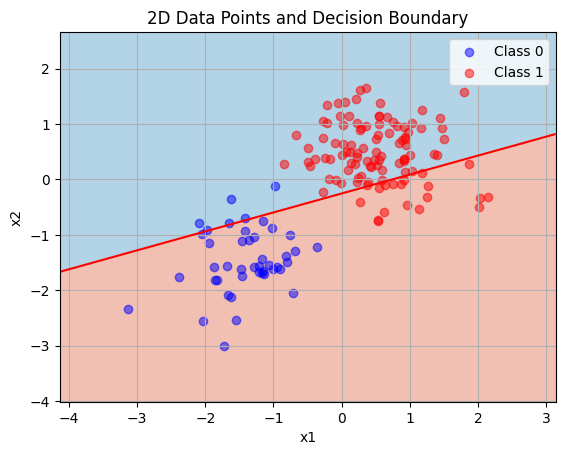

In [7]:

from src.models.Utils_Model import plot_decision_boundary
# Step 1: Forward Pass (Already done above)
# Step 2: Compute Loss Gradient
dloss = loss_func.backward(train_preds, y_train)

# Step 3: Backward Pass
gradients = classifier.backward(dloss)

# Step 4: Print Gradients
print("Gradients of the weights:\n", gradients)
plot_decision_boundary(dataset.validate_data, classifier=classifier)

### 2.4 Batch Gradient Descent
- After Computing The Whole Network and Averaging to a mean Gradient, we can now update weights and see the train loss changes

Updated Training Loss:             0.6918


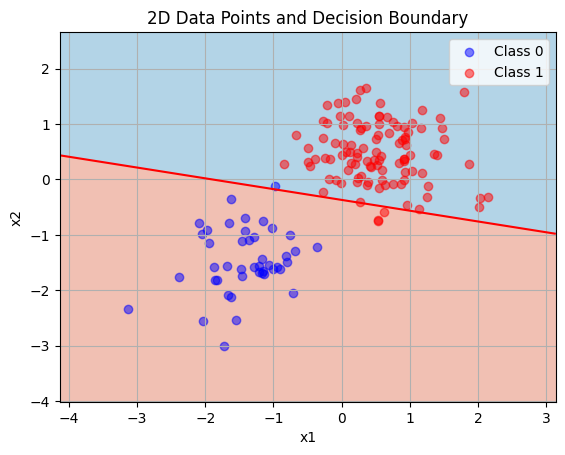

Updated Training Loss:             0.6910


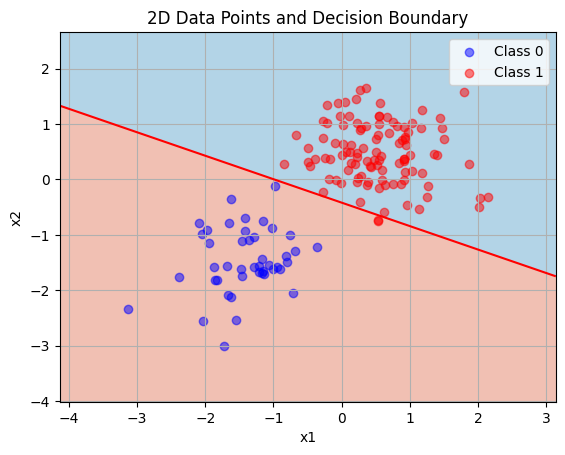

Updated Training Loss:             0.6901


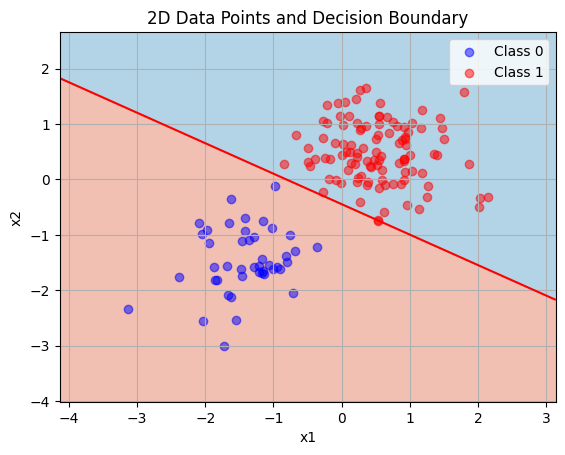

Updated Training Loss:             0.6892


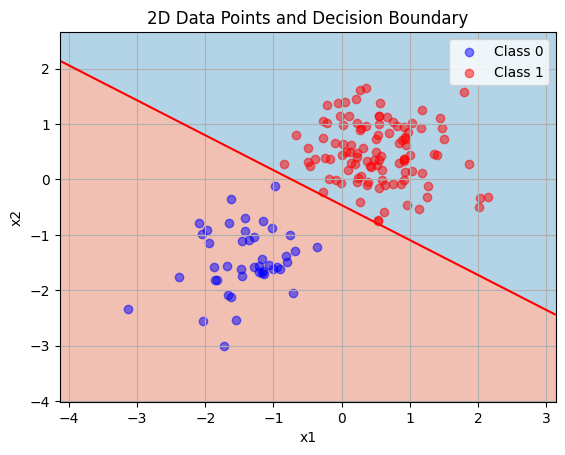

In [8]:
from src.models.Optimizer import Optimizer

for i in range(4):
    for x in range(20):
        for y in range(x):
            # Use the optimizer to update the model's weights based on the gradients
            optimizer = Optimizer(classifier, learning_rate=0.01)
            optimizer.step(gradients)

            # Re-evaluate the training loss after updating the weights
            train_preds_updated = classifier.forward(X_train)
            updated_train_loss = loss_func.forward(train_preds_updated, y_train)
    plot_decision_boundary(dataset.validate_data, classifier=classifier)
    print(f"Updated Training Loss: \
        {loss_func.forward(classifier.forward(X_train), y_train):.4f}")


### 2.5 Mini-Batch Gradient Descent

Epoch 1/200, Train Loss: 0.6728, Validation Loss: 0.6720
Epoch 6/200, Train Loss: 0.5997, Validation Loss: 0.5964
Epoch 11/200, Train Loss: 0.5391, Validation Loss: 0.5335
Epoch 16/200, Train Loss: 0.4881, Validation Loss: 0.4806
Epoch 21/200, Train Loss: 0.4445, Validation Loss: 0.4354
Epoch 26/200, Train Loss: 0.4070, Validation Loss: 0.3963
Epoch 31/200, Train Loss: 0.3745, Validation Loss: 0.3624
Epoch 36/200, Train Loss: 0.3459, Validation Loss: 0.3325
Epoch 41/200, Train Loss: 0.3207, Validation Loss: 0.3061
Epoch 46/200, Train Loss: 0.2983, Validation Loss: 0.2827
Epoch 51/200, Train Loss: 0.2784, Validation Loss: 0.2617
Epoch 56/200, Train Loss: 0.2605, Validation Loss: 0.2428
Epoch 61/200, Train Loss: 0.2445, Validation Loss: 0.2259
Epoch 66/200, Train Loss: 0.2301, Validation Loss: 0.2105
Epoch 71/200, Train Loss: 0.2170, Validation Loss: 0.1966
Epoch 76/200, Train Loss: 0.2051, Validation Loss: 0.1839
Epoch 81/200, Train Loss: 0.1943, Validation Loss: 0.1724
Epoch 86/200, Tr

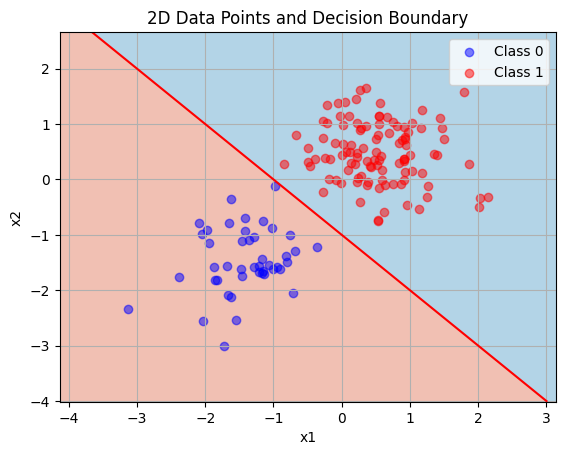

In [9]:
from src.Solver import Solver

solver = Solver(model=classifier, data={'X_train': X_train, 'y_train': y_train,
                                        'X_val': X_val, 'y_val': y_val},
                loss_func=loss_func, learning_rate=0.001, batch_size=32)
solver.train(epochs=200)
plot_decision_boundary(dataset.validate_data, classifier=classifier)